In [13]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef

hfont = {'fontname':'Helvetica'}

## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible', 'MSM',
       'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION', 'Midwest', 'Northeast',
       'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC',
       'DELTA_REGION', 'DELTA_CLINIC'],
      dtype='object')


In [14]:
### Get demographic data 

## To get summary stats, use original data 
CIP_data_full = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2005, 2006, 2007, 2008, 2009, 2010])]
print(CIP_data_full.columns)
total_obs = len(CIP_data_full)
print(total_obs)
#####
## initial stats for regional data 
#####
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

CIP_data_full['REGION'] = CIP_data_full['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) #drug_combinations = ['TetI']



regions = CIP_data_full['REGION'].unique()
regional_average = []
for region in regions:
    regional_data =len(CIP_data_full.loc[CIP_data_full['REGION'] == region])
    regional_average.append({region,(regional_data/total_obs)*100}) 
 
print(regional_average)
#####
## initial stats for gender data
#####

gendersps = CIP_data_full['GENDERSP'].unique()
gendersp_average = []
for gendersp in gendersps:
    gendersp_data =len(CIP_data_full.loc[CIP_data_full['GENDERSP'] == gendersp])
    gendersp_average.append({gendersp,(gendersp_data/total_obs)*100}) 
 
print(gendersp_average)

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible', 'MSM',
       'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION', 'Midwest', 'Northeast',
       'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC',
       'DELTA_REGION', 'DELTA_CLINIC'],
      dtype='object')
35330
[{'Southwest', 14.817435607132747}, {18.497028021511465, 'Southeast'}, {11.485989244268326, 'Northeast'}, {'Midwest', 20.02830455703368}, {35.17124257005378, 'West'}]
[{'MSW', 74.93065383526748}, {'MSM', 19.24426832720068}, {3.7305406170393436, 'MSMW'}, {2.0945372204924992, 'Oth/Unk/Missing'}]


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_63734/3876156617.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CIP_data_full['REGION'] = CIP_data_full['CLINIC'].apply(lambda x:


In [15]:
############# data

#nn_data 
best_features_by_year_nn ={2005: {'solver': 'adam',
  'random_state': 219,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (13,),
  'alpha': 0.16991441720346265,
  'activation': 'relu'}, 2006: {'solver': 'adam',
  'random_state': 219,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (13,),
  'alpha': 0.16991441720346265,
  'activation': 'relu'}, 2007: {'solver': 'adam',
  'random_state': 219,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (13,),
  'alpha': 0.16991441720346265,
  'activation': 'relu'}, 2008:{'solver': 'adam',
  'random_state': 219,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (13,),
  'alpha': 0.16991441720346265,
  'activation': 'relu'}, 2009: {'solver': 'adam',
  'random_state': 219,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (13,),
  'alpha': 0.16991441720346265,
  'activation': 'relu'}, 2010: {'solver': 'adam',
  'random_state': 219,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (13,),
  'alpha': 0.16991441720346265,
  'activation': 'relu'}}
best_features_by_year_nn = {2005: ['DELTA_CLINIC',
  'MSM',
  'MSW',
  'Southeast',
  'Southwest',
  'MSMW',
  'PREV_CLINIC',
  'Oth/Unk/Missing'],
 2006: ['DELTA_CLINIC',
  'MSM',
  'PREV_CLINIC',
  'MSW',
  'DELTA_REGION',
  'PREV_REGION',
  'MSMW',
  'Oth/Unk/Missing',
  'Southeast',
  'Northeast'],
 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'MSMW', 'Oth/Unk/Missing'],
 2008: ['DELTA_CLINIC',
  'West',
  'PREV_CLINIC',
  'MSM',
  'Southwest',
  'Oth/Unk/Missing',
  'Midwest',
  'DELTA_REGION'],
 2009: ['DELTA_CLINIC', 'DELTA_REGION', 'West', 'Midwest', 'Southeast'],
 2010: ['DELTA_CLINIC', 'West', 'DELTA_REGION', 'Northeast']}
ROC_by_year_nn = {2005: 0.7398504273504273, 2006: 0.7382176116296877, 2007: 0.6843493552168816, 2008: 0.6859337105901373, 2009: 0.639923472636795, 2010: 0.6679718875502009}

#lr_data 
best_hyperparameters_by_year_lr = {2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}, 2009: {'solver': 'liblinear', 'penalty': 'l2', 'C': 83.42}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}}
best_features_by_year_lr = {2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSW', 'Southwest', 'Northeast', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSM', 'PREV_CLINIC', 'MSW', 'Oth/Unk/Missing', 'MSMW'], 2008: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing', 'Northeast'], 2009: ['PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC', 'Northeast'], 2010: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'Northeast']}
ROC_by_year_lr = {2005: 0.7317511805463615, 2006: 0.7423710317796873, 2007: 0.7048918256421187, 2008: 0.6971529715492738, 2009: 0.6166128405256475, 2010: 0.6792793175522966}
##rf_paper 
best_hyperparameters_by_year_rf = {2005: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2006: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2007: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2008: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2009: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2010: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}}
best_features_by_year_rf = {2005: ['MSW', 'MSM', 'MSMW'], 2006: ['MSW', 'DELTA_CLINIC', 'MSM', 'MSMW', 'Oth/Unk/Missing'], 2007: ['MSW', 'PREV_CLINIC', 'MSM'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'Oth/Unk/Missing', 'Southeast'], 2009: ['MSW', 'MSM', 'PREV_CLINIC', 'DELTA_CLINIC', 'PREV_REGION', 'Midwest'], 2010: ['DELTA_CLINIC', 'PREV_CLINIC', 'MSW', 'PREV_REGION', 'West', 'DELTA_REGION', 'Midwest', 'Southeast', 'MSMW']}
ROC_by_year_rf = {2005: 0.7418091168091168, 2006: 0.6955865853135346, 2007: 0.6980265728800312, 2008: 0.7012934518997574, 2009: 0.6612742833389195, 2010: 0.6738955823293172}

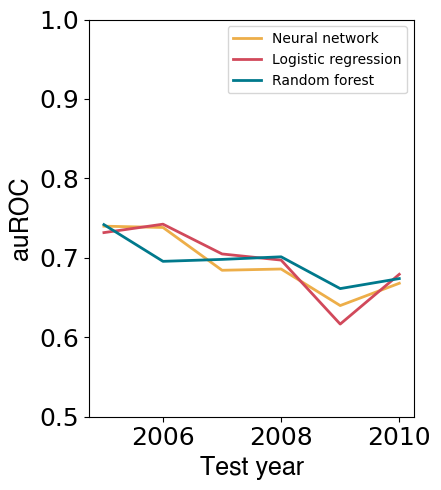

In [5]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr 
fig, axs = plt.subplots(figsize=(4.5, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)

#axs[0].plot(years, ROC_by_year_nn.values())
#axs[1].plot(years, ROC_by_year_lr.values())
#axs[2].plot(years, ROC_by_year_rf.values())

axs.plot(years, ROC_by_year_nn.values(),linewidth = 2, label = "Neural network", color = "#edae49")
axs.plot(years, ROC_by_year_lr.values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.plot(years, ROC_by_year_rf.values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Test year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend()
plt.tight_layout()

#plt.savefig('Graphs/auROC_by_year_all_models.png', dpi = 600)


In [17]:
########### Try functionalised 


def effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prevalence):

    get_effective_threshold = []
    incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )

        sensitivity_threshold.append(sensitivity_test*100)
        specificity_threshold.append(specificity_test*100)
        get_effective_threshold.append(sensitivity_test * cipro_R_prevalence*100 + (100 -  cipro_R_prevalence*100)) #q_p
        incorrectly_get_X_threshold.append((100 - cipro_R_prevalence*100) * (1 - specificity_test)) #c_p"
    return(sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold)

def get_best_hyperparameters(model, cv, space, X_train, y_train):
        search = RandomizedSearchCV(model, space, scoring='roc_auc', n_iter=1,  n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return(result.best_params_)

def get_best_features(feature_names, model_fit, X_test, y_test):
    PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - 2 * PI.importances_std[q] > 0:
          important_features.append(feature_names[q]) #works cos they are in same order as the x columns
    return(important_features)


oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)

def get_test_train_data_overfit(CIP_data_no_drop, year, feature_names, oversample_size):
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[feature_names] #need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data['Susceptible']
    cipro_R = y_test.sum()/len(y_test) 
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    return(test_data, train_data, X_train, y_train, X_test, y_test, cipro_R)


def get_test_train_data(CIP_data_no_drop, year, feature_names):
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[feature_names] #need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data['Susceptible']
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data['Susceptible']
    return(test_data, train_data, X_train, y_train, X_test, y_test)

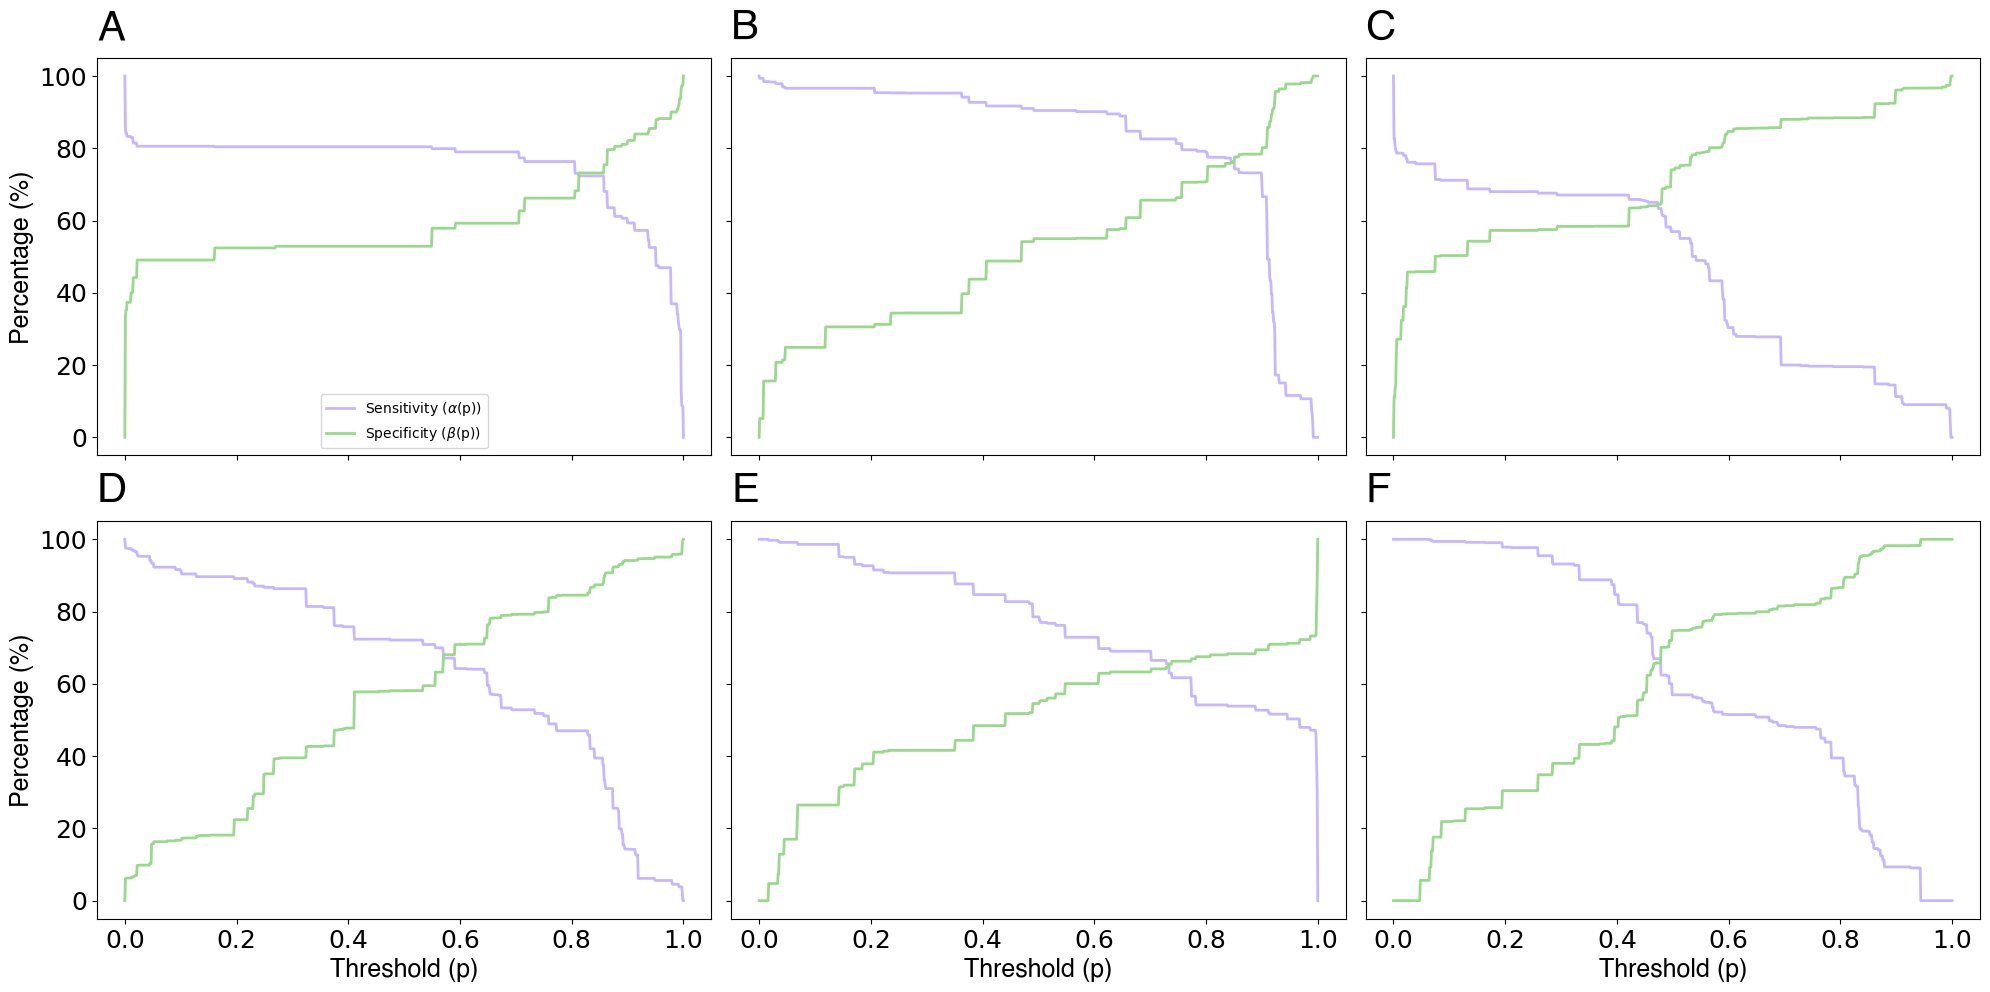

In [106]:
### Do the sensitivity by year, too... Neural network 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,1001)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size = 0.5)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )
    
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity ($\alpha$(p))", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity ($\beta$(p))", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()

#plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_neural_network_2005_2010.png", dpi = 600)


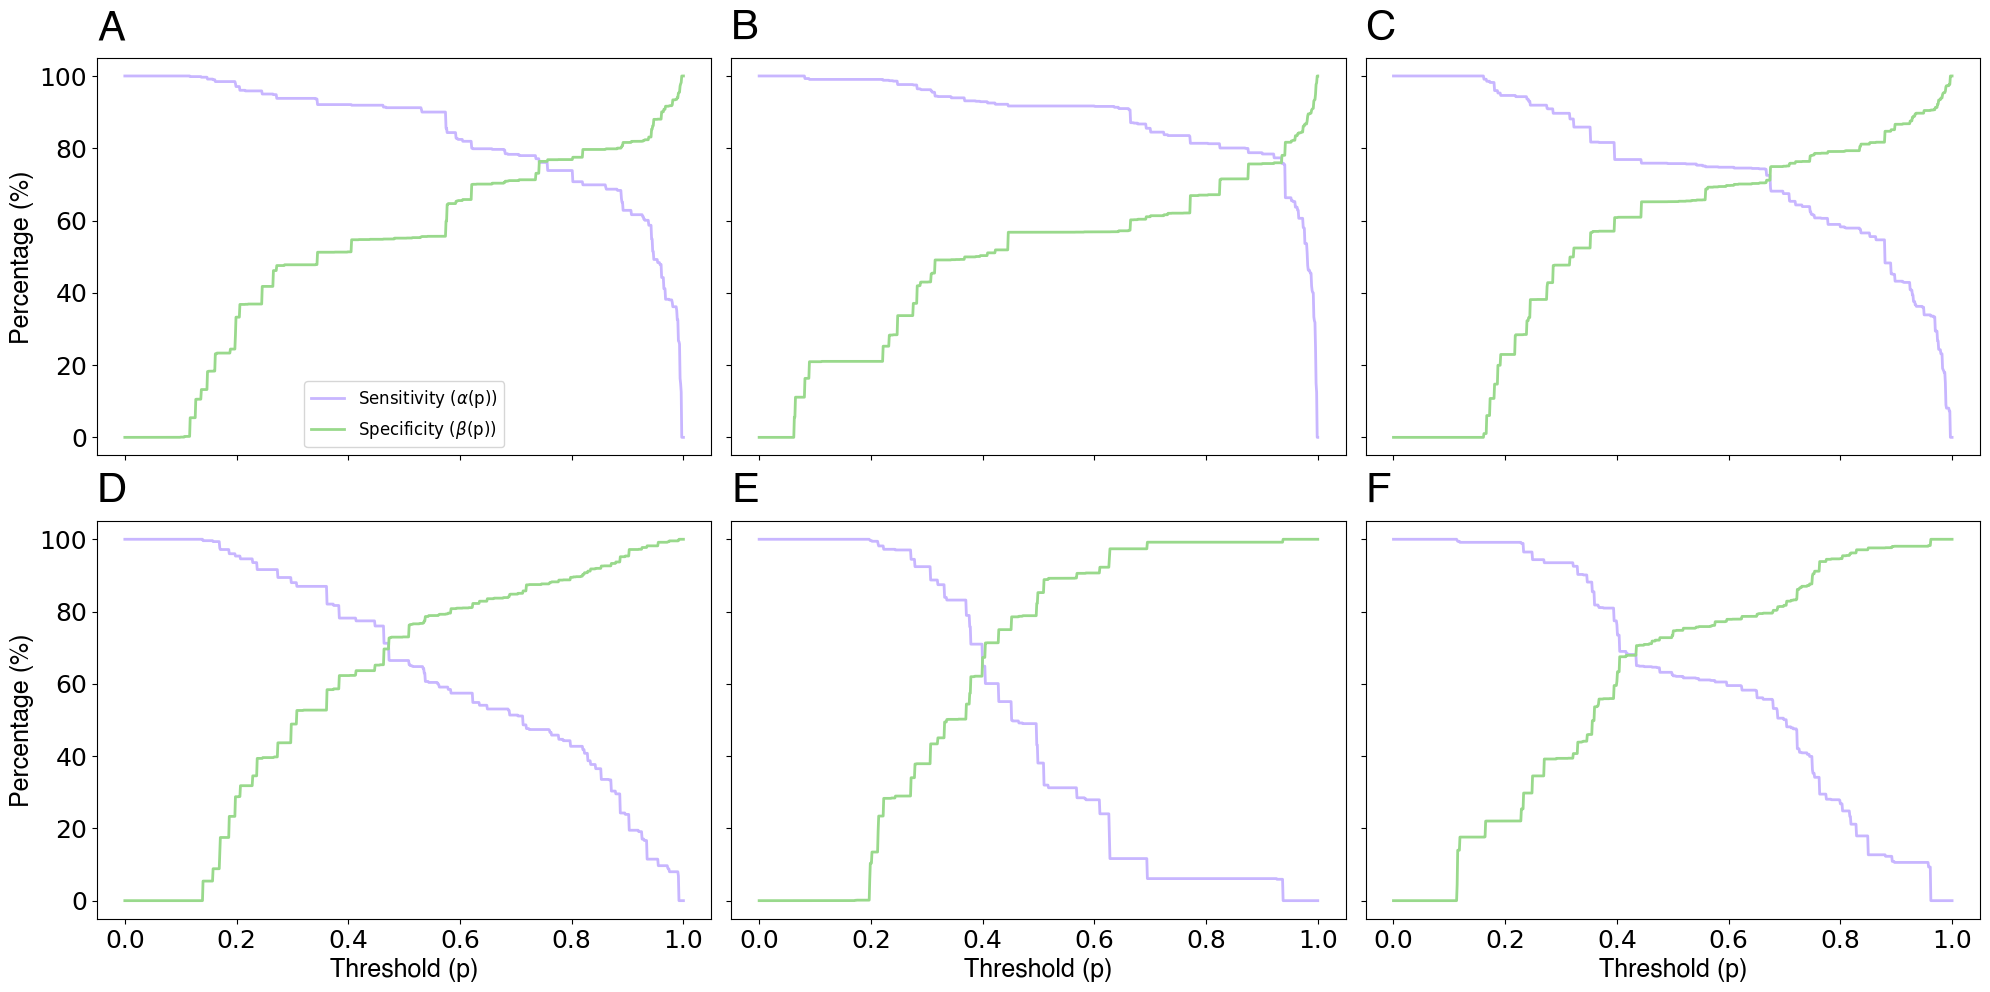

In [107]:
### Do the sensitivity by year, too... logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
axs[0,0].set_ylabel('Percentage (%)', fontsize = 18, **hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize = 18, **hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize = 18, **hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize = 18, **hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize = 18, **hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize = 18, **hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,1001)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year])

    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])
    cipro_R_prev = y_test.sum()/len(y_test)
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity ($\alpha$(p))", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity ($\beta$(p))", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1

axs[0].legend(prop={'size': 12})
plt.tight_layout()

#plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_logistic_regression_2005_2010.png", dpi = 600)

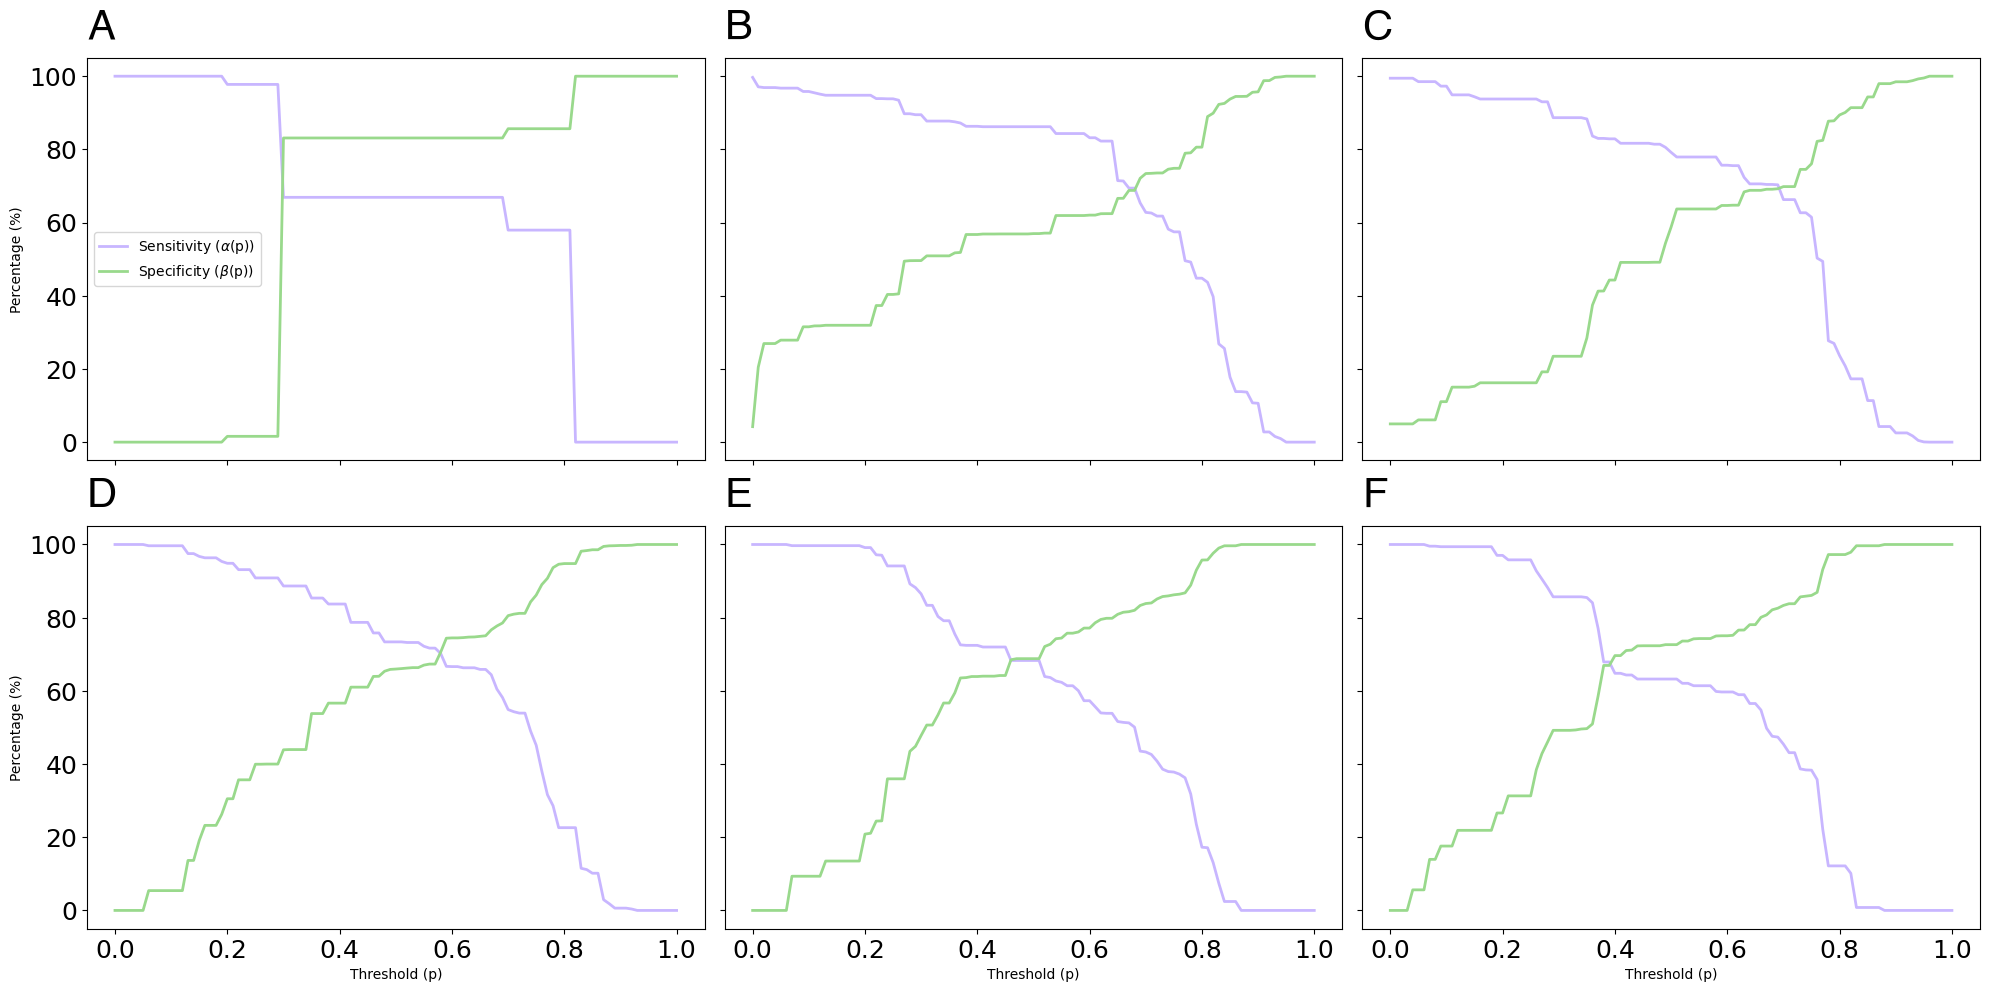

In [109]:
### Do the sensitivity by year, too... random forest 

### Do the sensitivity by year, too... logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
axs[0,0].set_ylabel('Percentage (%)')
axs[1,0].set_ylabel('Percentage (%)')
axs[1,0].set_xlabel('Threshold (p)')
axs[1,1].set_xlabel('Threshold (p)')
axs[1,2].set_xlabel('Threshold (p)')

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year], oversample_size = 0.5)

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity ($\alpha$(p))", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity ($\beta$(p))", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()

#plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_random_forest_2005_2010.png", dpi = 600)

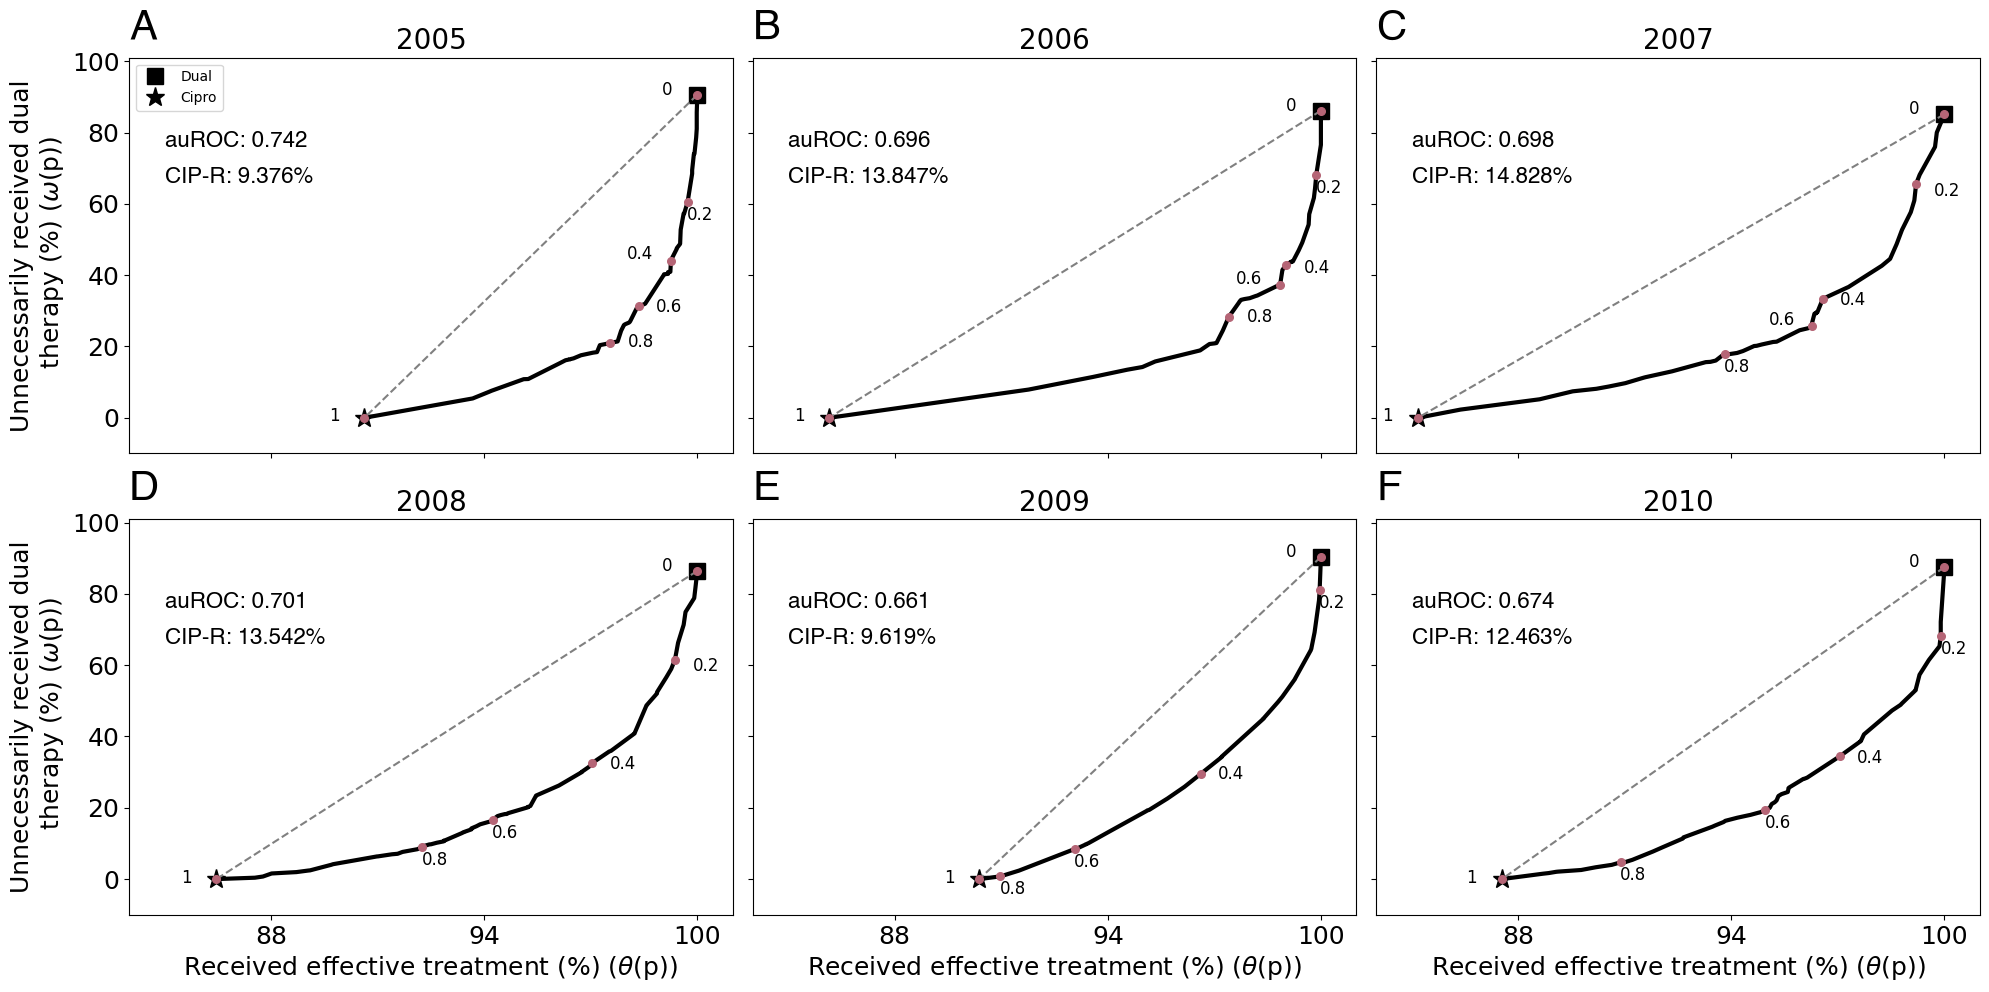

In [93]:
###### Effect of threshold on year-by-year for logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)

i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year])
    cipro_R_prev = y_test.sum()/len(y_test)
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 25, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
 
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index == 100:
            axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] - 1, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index], text_for_graph[x], size = 12)
        elif (get_effective_threshold[index] > 95) & (get_effective_threshold[index] < 99.6):
            if abs(get_effective_threshold[index] - get_effective_threshold[index-20]) < 0.5:
                if (incorrectly_get_X_threshold[index] - incorrectly_get_X_threshold[index-20] < 1):
                    axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*1.01, text_for_graph[x], size = 12)#, color = "blue")
                else:
                    axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "green")
            else:
                axs[i].text(get_effective_threshold[index]*1.005, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "red")
        
        else:
            axs[i].text(get_effective_threshold[index]- 0.01, incorrectly_get_X_threshold[index]-5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()
axs[0].legend()
#plt.savefig('Graphs/Percent_effective_unnecessary_all_logistic_regression_2005_2010.png')
#

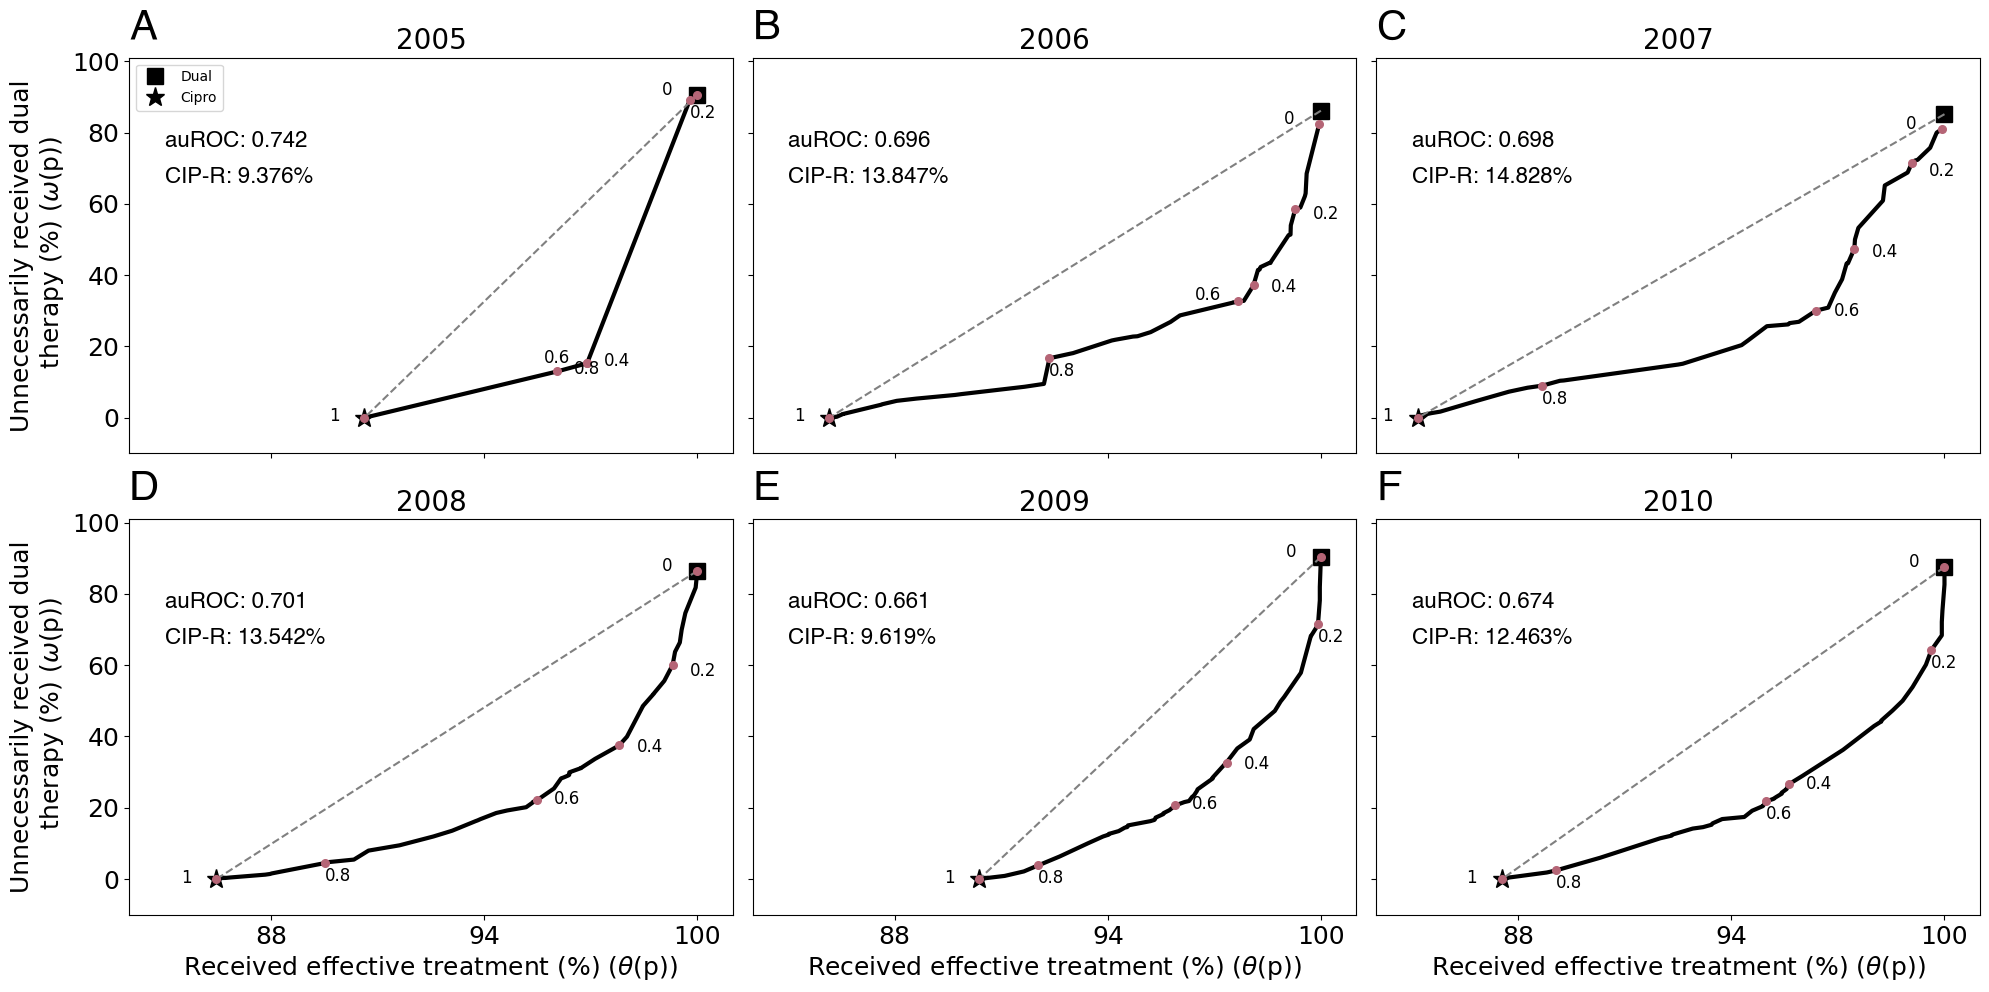

In [94]:
###### Effect of threshold on year-by-year for random forest model 

fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])

axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)

i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year], oversample_size = 0.5)

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20) 
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 25, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
  
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index == 100:
            axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] - 1, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index], text_for_graph[x], size = 12)
        elif (get_effective_threshold[index] > 95) & (get_effective_threshold[index] < 99.6):
            if abs(get_effective_threshold[index] - get_effective_threshold[index-20]) < 0.5:
                if (incorrectly_get_X_threshold[index] - incorrectly_get_X_threshold[index-20] < 1):
                    axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*1.01, text_for_graph[x], size = 12)#, color = "blue")
                else:
                    axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "green")
            else:
                axs[i].text(get_effective_threshold[index]*1.005, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "red")
        
        else:
            axs[i].text(get_effective_threshold[index]- 0.01, incorrectly_get_X_threshold[index]-5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()

axs[0].legend()
#plt.savefig('Graphs/Percent_effective_unnecessary_all_random_forest_2005_2010.png')
#

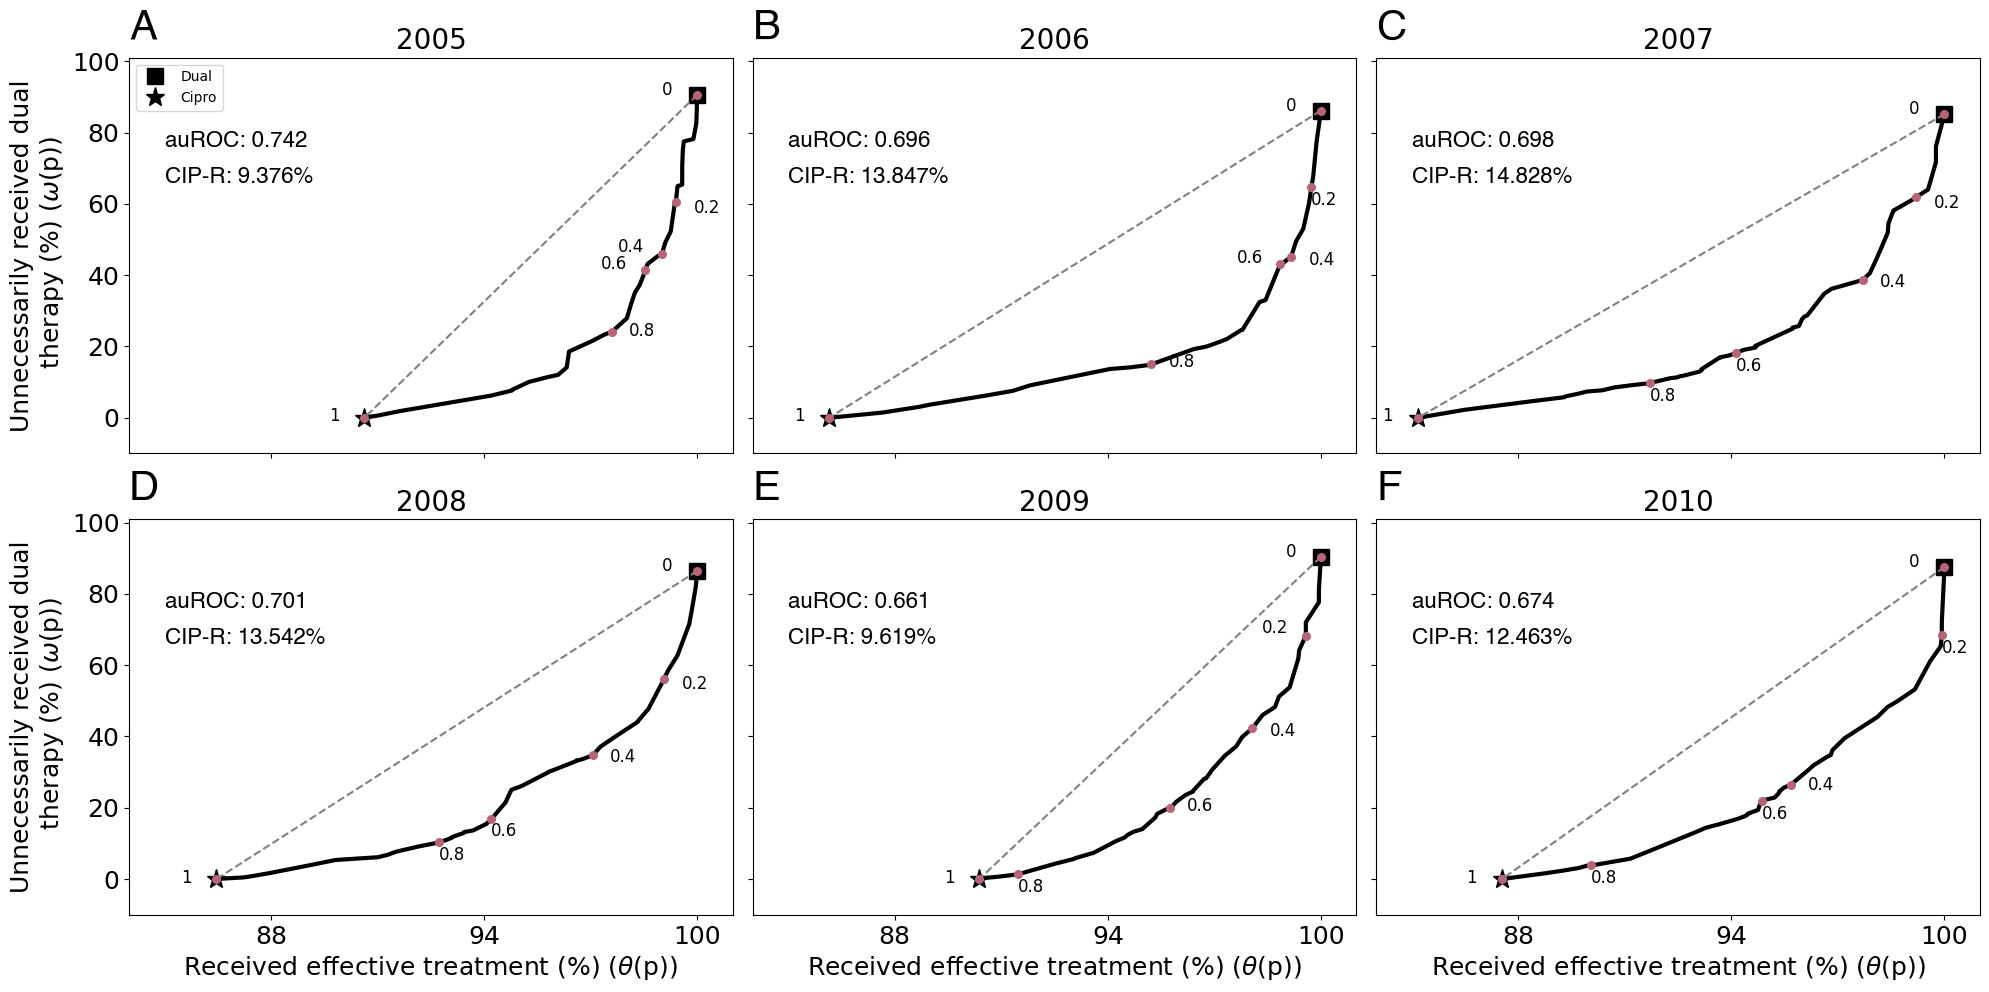

In [72]:
###### Effect of threshold on year-by-year for neural network
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
#text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
#indices = [0,10,20,30,40,50,60,70,80,90,100]

text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])

axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = best_hyperparameters_by_year_nn[year]['learning_rate'] )

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size=0.5)
   
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)   
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 25, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index == 100:
            axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] - 1, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index], text_for_graph[x], size = 12)
        elif (get_effective_threshold[index] > 95) & (get_effective_threshold[index] < 99.6):
            if abs(get_effective_threshold[index] - get_effective_threshold[index-20]) < 0.5:
                if (incorrectly_get_X_threshold[index] - incorrectly_get_X_threshold[index-20] < 1):
                    axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*1.01, text_for_graph[x], size = 12)#, color = "blue")
                else:
                    axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "green")
            else:
                axs[i].text(get_effective_threshold[index]*1.005, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "red")
        
        else:
            axs[i].text(get_effective_threshold[index]- 0.01, incorrectly_get_X_threshold[index]-5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()
axs[0].legend()
#plt.savefig('Graphs/Percent_effective_unnecessary_all_neural_network_2005_2010.png')

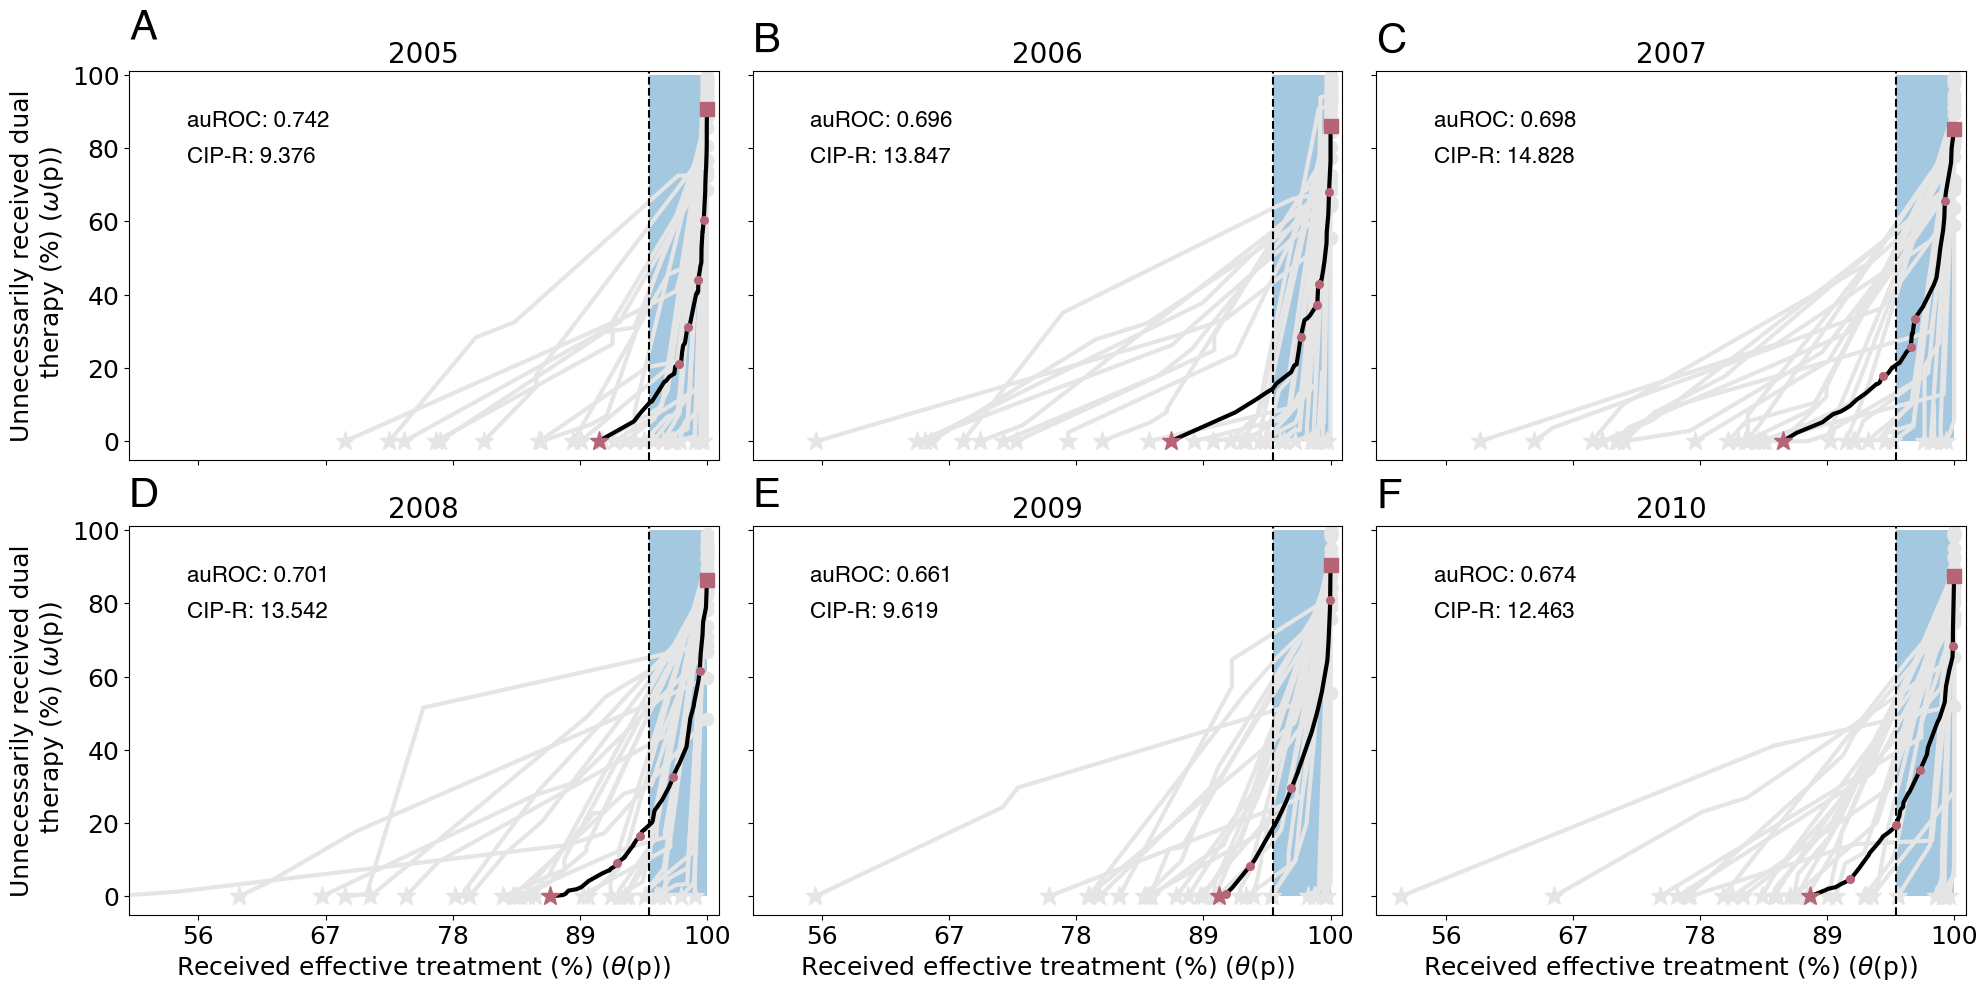

In [24]:
### Leave one out validation for logistic regression 
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)



fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year])
    cipro_R_prev = y_test.sum()/len(y_test)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])
    
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_rf[year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_rf[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 

              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              index_for_plot = np.max(np.where(np.array(get_effective_threshold_clinic)>95))

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, 100 - cipro_R_prev*100, marker='s', ls='none', ms=10, color = "#b56576")
    axs[i].plot((100-cipro_R_prev*100), 0, marker='*', ls='none', ms=14, color = "#b56576")
    axs[i].text(50, axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([50, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 15, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 25, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    for index in indices:
        axs[i].plot(get_effective_threshold_all[index], incorrectly_get_X_threshold_all[index], marker='.', ls='none', ms=11, color = "#b56576")
    axs[i].set_title(year,fontsize=20)   

    i += 1   #

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)

plt.tight_layout()
#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_logistic_regression_2005_2010.png", dpi = 600)

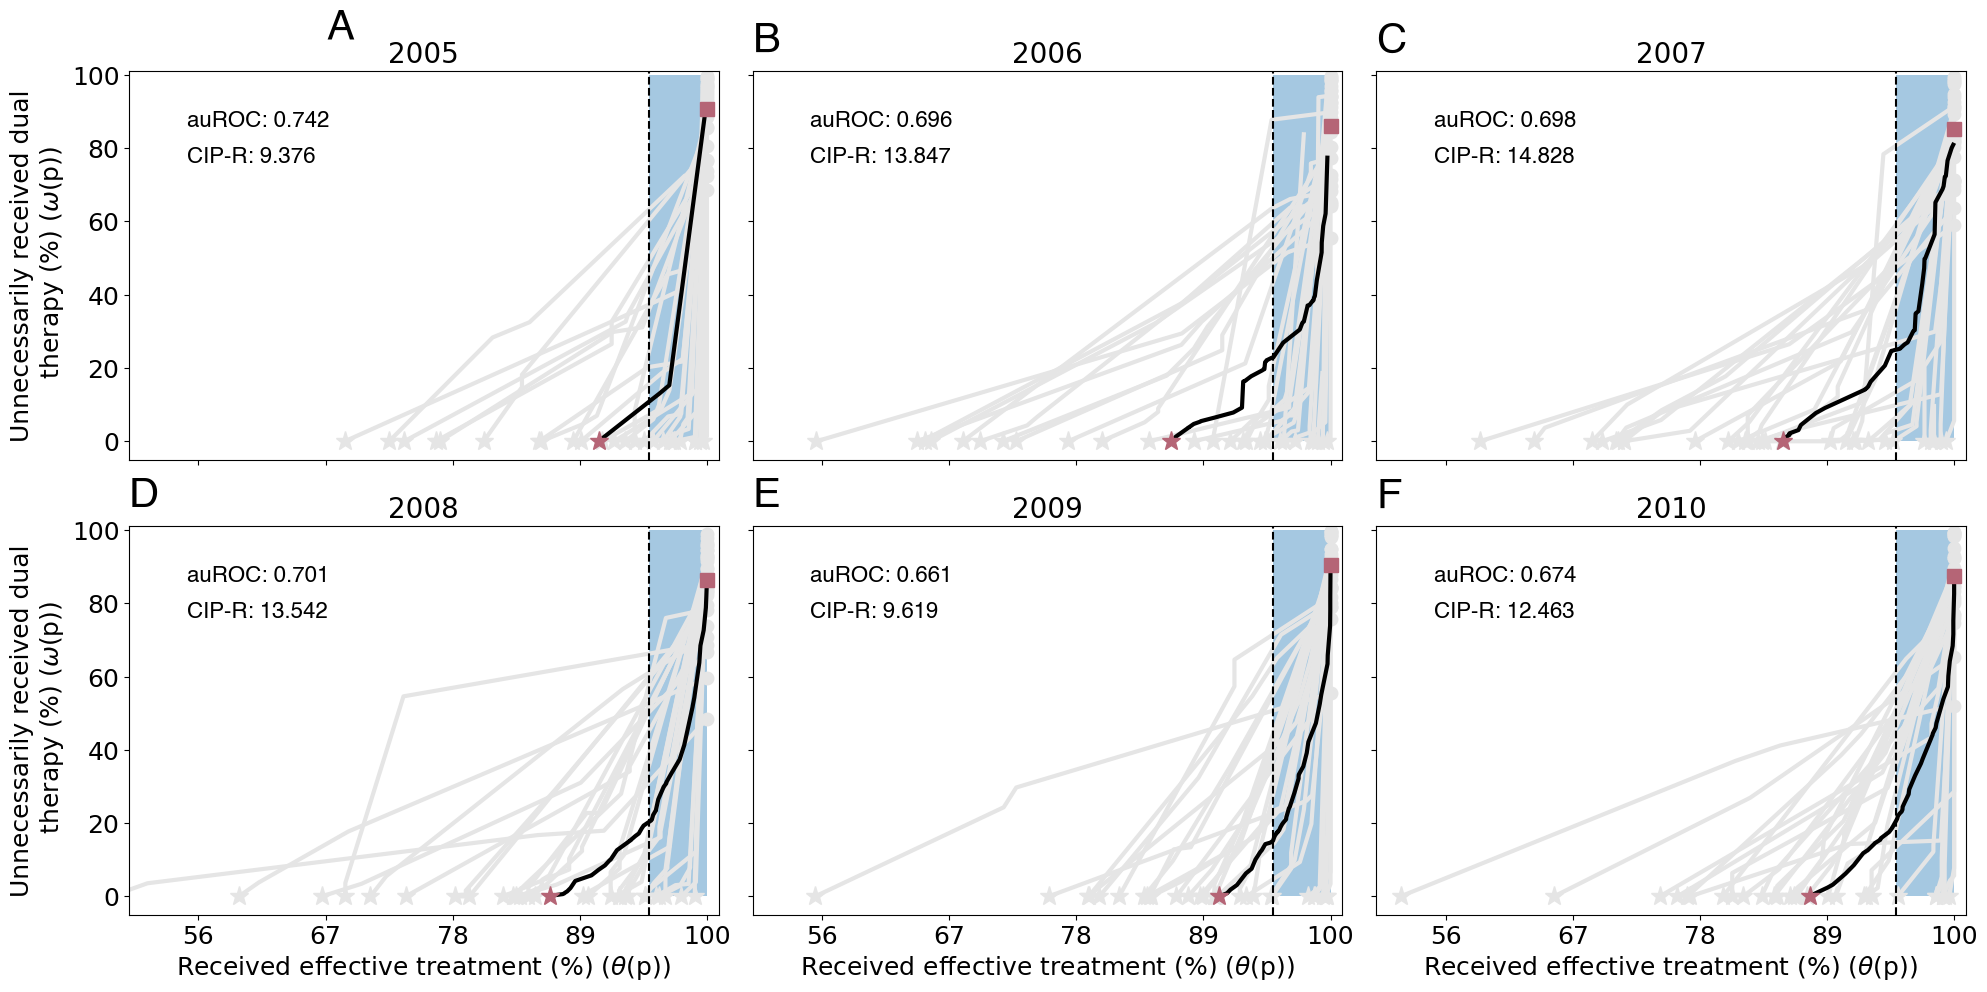

In [22]:
### Leave one out validation for random forest
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

##"full model"
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)



fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names =best_features_by_year_rf[year], oversample_size = 0.5)

    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train)
 
    ## fit model w/hyperparameters 
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_rf[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_rf[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              index_for_plot = np.max(np.where(np.array(get_effective_threshold_clinic)>95))

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   

          
          except ValueError:
            try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              index_for_plot = np.max(np.where(np.array(get_effective_threshold_clinic)>95))

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3,alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")

            except ValueError:
              print('x')
              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, 100 - cipro_R_prev*100, marker='s', ls='none', ms=10, color = "#b56576")
    axs[i].plot((100-cipro_R_prev*100), 0, marker='*', ls='none', ms=14, color = "#b56576")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([50, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 15, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 25, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   

    i += 1   #


axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.tight_layout()
#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_random_forest_2005_2010.png", dpi = 600)

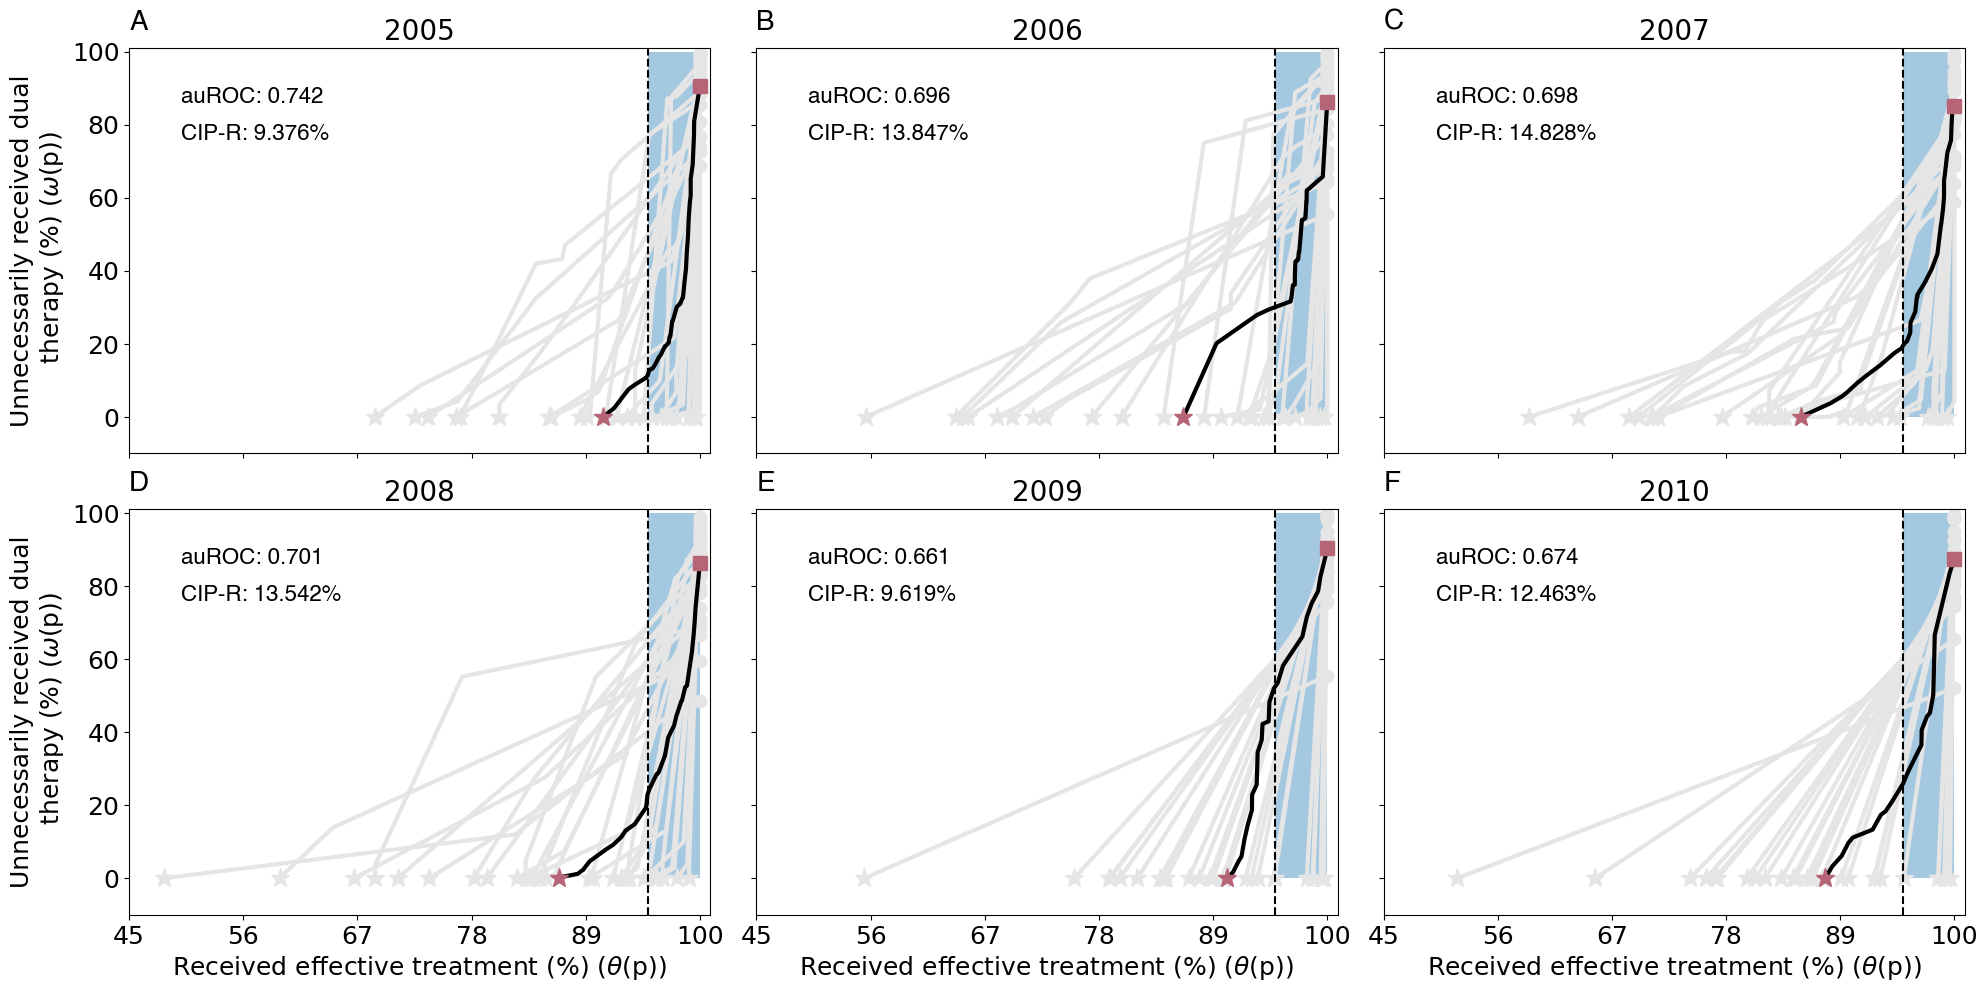

In [19]:
### Leave one out validation for MLP 
from matplotlib.patches import Polygon
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
labels = ["A", "B", "C", "D", "E", "F" ]

polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
threshold_seq = np.linspace(0,1,101)

fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)

test_years = [2005, 2006, 2007, 2008, 2009, 2010]
#test_years = [2005]
axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([45, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size = 0.5)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[ best_features_by_year_nn[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[ best_features_by_year_nn[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          #print(cipro_R)
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   

          
          except ValueError:
            #try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=1)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              #y_test.astype(y_predict_test.dtype)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   


            #except ValueError:
              #print('x')
              #pass
    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, 100 - cipro_R_prev*100, marker='s', ls='none', ms=10, color = "#b56576")
    axs[i].plot((100-cipro_R_prev*100), 0, marker='*', ls='none', ms=14, color = "#b56576")
    axs[i].text(axs[i].get_xlim()[0], axs[i].get_ylim()[1] + 5, labels[i], fontsize = 20, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 15, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 25, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    #for index in indices:
    #    axs[i].plot(get_effective_threshold_all[index], incorrectly_get_X_threshold_all[index], marker='.', ls='none', ms=11, color = "#b56576")
    axs[i].set_title(year,fontsize=20)

    i += 1   #

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.tight_layout()

#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_neural_network_2005_2010.png", dpi = 600)

In [83]:
### change for 2007 - neural network 
year = 2010
years_train = np.array(range(year - 5, year))
threshold_seq = np.linspace(0,1,1001)

    # first do for all clinics 



test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size = 0.5)

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )
    
    ## fit model
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
 
senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

print(get_effective_threshold_all[0])
print(incorrectly_get_X_threshold_all[0])

print(get_effective_threshold_all[200])
print(incorrectly_get_X_threshold_all[200])


print((get_effective_threshold_all[0] - get_effective_threshold_all[200])/(get_effective_threshold_all[0]))
print((incorrectly_get_X_threshold_all[0] - incorrectly_get_X_threshold_all[200])/(incorrectly_get_X_threshold_all[0]))

100.0
87.5373527860784
99.72972572307158
60.889435753207955
0.0027027427692841856
0.30441767068273085


In [40]:

############# why does it decrease over time??? 
space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =  1.29, random_state=10, learning_rate = 'adaptive' )

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2004, 2005, 2006, 2007, 2008])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train,y_train)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train,y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#2010 {'hidden_layer_sizes': 14, 'alpha': 0.1, 'activation': 'tanh'} different to what came from loop...

Best Score: 0.824477493687889
Best Hyperparameters: {'hidden_layer_sizes': 14, 'alpha': 0.1, 'activation': 'tanh'}


In [102]:
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 14, alpha =  0.1, random_state=10, learning_rate = 'adaptive' )

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2005, 2006, 2007, 2008, 2009])]
X_train = train_data[best_features_by_year_nn[2010]]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2010])]

X_test = test_data[best_features_by_year_nn[2010]]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)
model_fit_train = model_nn.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_nn_2010= metrics.roc_auc_score(y_test, y_predict)

print(ROC_AUC_nn_2010)


KeyboardInterrupt: 

In [33]:
### How to pick out best features by model 
years = [2005, 2006, 2007, 2008, 2009, 2010]

### neural network
PI_dataframe_nn = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0, 
'Delta_R':0,
'Delta_C':0
},index=[0])
for year in years:
    for feature in best_features_by_year_nn[year]:
        if feature == 'PREV_CLINIC':
                PI_dataframe_nn["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe_nn["Region"] += 1
        elif feature == "MSM":
                PI_dataframe_nn["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe_nn["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe_nn["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe_nn["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe_nn["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe_nn["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe_nn["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe_nn["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe_nn["West"] += 1   
        elif feature == "DELTA_REGION":
                PI_dataframe_nn["Delta_R"] += 1
        elif feature == "DELTA_CLINIC":
                PI_dataframe_nn["Delta_C"] += 1
PI_dataframe_nn = pd.melt(PI_dataframe_nn, value_vars=PI_dataframe_nn.columns)

## logistic regression
PI_dataframe_lr = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0, 
'Delta_R':0,
'Delta_C':0},index=[0])
for year in years:
    for feature in best_features_by_year_lr[year]:
        if feature == 'PREV_CLINIC':
                PI_dataframe_lr["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe_lr["Region"] += 1
        elif feature == "MSM":
                PI_dataframe_lr["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe_lr["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe_lr["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe_lr["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe_lr["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe_lr["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe_lr["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe_lr["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe_lr["West"] += 1   
        elif feature == "DELTA_REGION":
                PI_dataframe_lr["Delta_R"] += 1
        elif feature == "DELTA_CLINIC":
                PI_dataframe_lr["Delta_C"] += 1
PI_dataframe_lr = pd.melt(PI_dataframe_lr, value_vars=PI_dataframe_lr.columns)

## random forest 
PI_dataframe_rf = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0, 
'Delta_R':0,
'Delta_C':0},index=[0])
for year in years:
    for feature in best_features_by_year_rf[year]:
        if feature == 'PREV_CLINIC':
                PI_dataframe_rf["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe_rf["Region"] += 1
        elif feature == "MSM":
                PI_dataframe_rf["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe_rf["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe_rf["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe_rf["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe_rf["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe_rf["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe_rf["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe_rf["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe_rf["West"] += 1   
        elif feature == "DELTA_REGION":
                PI_dataframe_rf["Delta_R"] += 1
        elif feature == "DELTA_CLINIC":
                PI_dataframe_rf["Delta_C"] += 1
PI_dataframe_rf = pd.melt(PI_dataframe_rf, value_vars=PI_dataframe_rf.columns)


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_88221/1102679014.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels( PI_dataframe_nn["variable"],fontsize = 18)


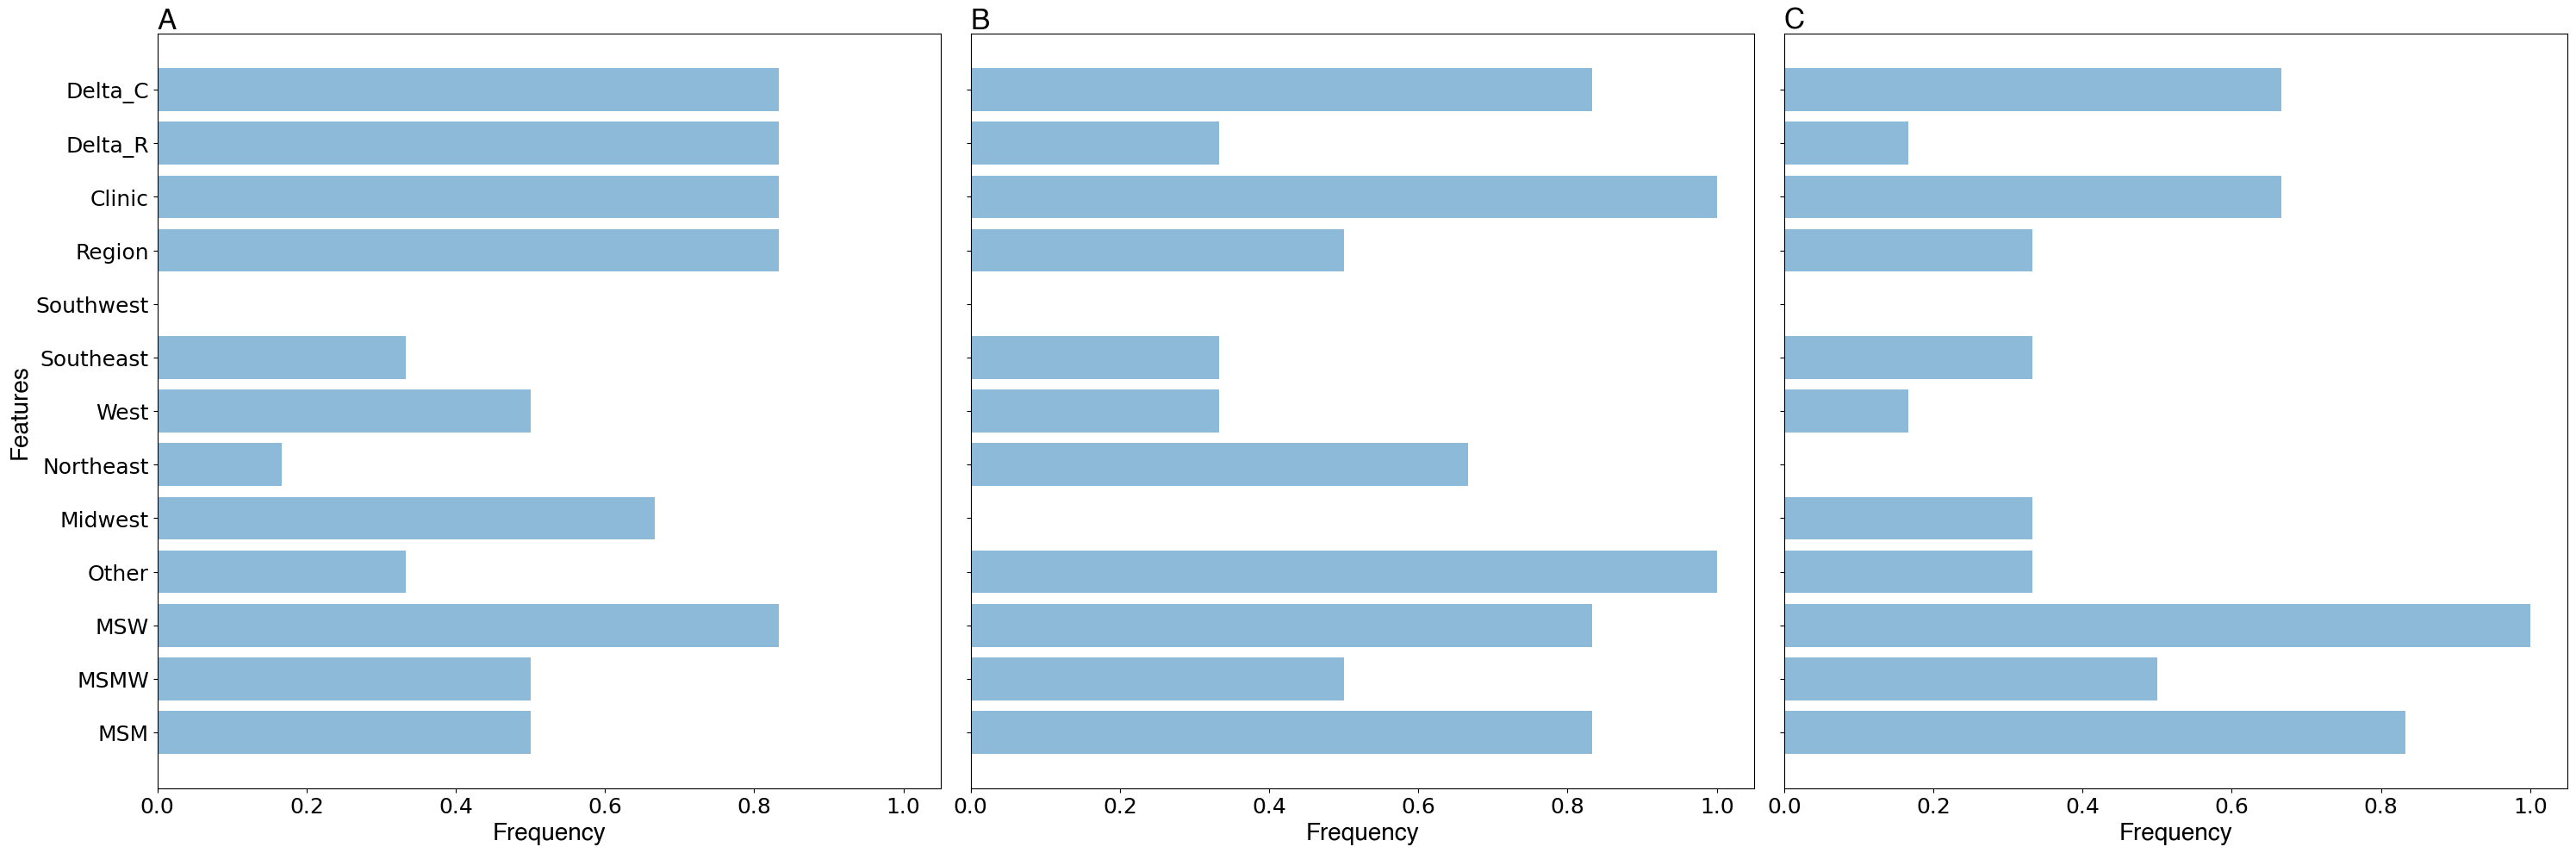

In [35]:
fig, axs = plt.subplots(1,3, figsize=(30, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0].barh(y = PI_dataframe_nn["variable"], width =PI_dataframe_nn["value"]/6,alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[1].barh(y = PI_dataframe_lr["variable"], width =PI_dataframe_lr["value"]/6,alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[2].barh(y = PI_dataframe_rf["variable"], width =PI_dataframe_rf["value"]/6,alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[0].set_xlabel('Frequency', fontsize = 20, **hfont)
axs[1].set_xlabel('Frequency', fontsize = 20, **hfont)
axs[2].set_xlabel('Frequency', fontsize = 20, **hfont)
axs[0].set_ylabel('Features', fontsize = 20, **hfont)

axs[0].set_yticklabels( PI_dataframe_nn["variable"],fontsize = 18)
axs[0].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='x', labelsize=18)
axs[2].tick_params(axis='x', labelsize=18)

axs[0].text(axs[0].get_xlim()[0] , axs[0].get_ylim()[1] + .1, "A", fontsize = 24, **hfont)
axs[1].text(axs[0].get_xlim()[0] , axs[0].get_ylim()[1] + .1, "B", fontsize = 24, **hfont)
axs[2].text(axs[0].get_xlim()[0] , axs[0].get_ylim()[1] + .1, "C", fontsize = 24, **hfont)
plt.tight_layout()

#plt.savefig('Graphs/Features_by_frequency_all_models.png', dpi = 600)


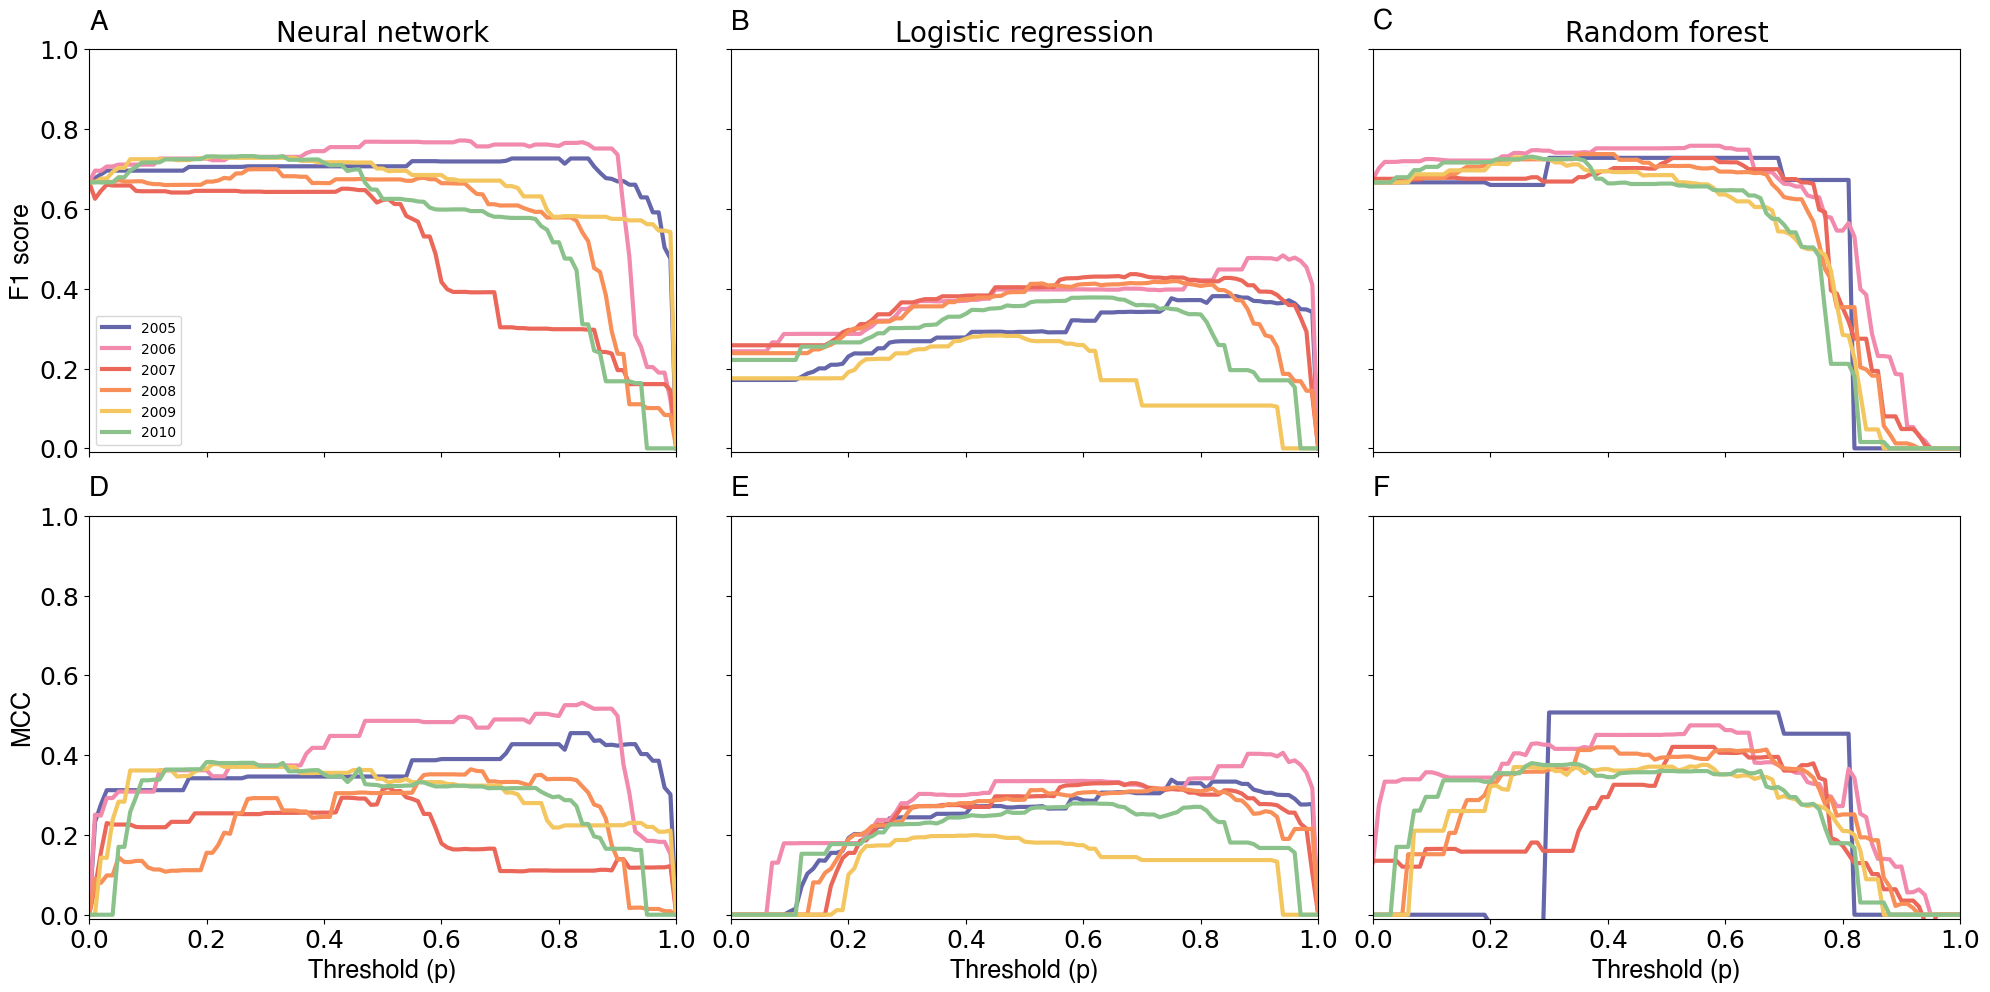

In [99]:
###### Performance criteria by year and model 
def f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test):

    f1_score_seq = []
    mcc_score_seq = []
    for threshold in threshold_seq:

        y_predict = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        f1_score_seq.append(f1_score(y_test, y_predict))
        mcc_score_seq.append(matthews_corrcoef(y_test, y_predict))
    return(f1_score_seq, mcc_score_seq)

## set up for figure 

### calculate scores 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
colors = ["#6667ab", "#f18aad", "#ea6759", "#f88f58", "#f3c65f", "#8bc28c"]
labels = ["A", "B", "C", "D", "E", "F" ]

test_years = [2005, 2006, 2007, 2008, 2009, 2010]

axs[0,0].set_ylabel('F1 score', fontsize = 18, **hfont)
axs[1,0].set_ylabel('MCC', fontsize = 18, **hfont)
axs[1,0].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,1].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,2].set_xlabel("Threshold (p)", fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_ylim([0-.010,1])
axs[0,0].set_xlim([0, 1])

axs = axs.ravel()

for i in range(3):
    x = 0

    if i == 0:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))

            # first do for all clinics 

            model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size = 0.5)

            ## fit model w/hyperparameters 
            model_fit = model_nn.fit(X_train, y_train)
            y_predict_test = model_fit.predict(X_test)
            y_predict_proba = model_fit.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Neural network",fontsize=20)
        axs[i].legend()


    if i == 1:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))

            # first do for all clinics 

            model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])

            test_data, train_data, X_train, y_train, X_test, y_test =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year])

            ## fit model w/hyperparameters 
            model_fit_train = model_lr.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
   
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Logistic regression",fontsize=20)

    
    if i == 2:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))

            model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)

            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names =best_features_by_year_rf[year], oversample_size = 0.5)
        
            model_fit_train = model_rf.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)

            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Random forest",fontsize=20)

plt.tight_layout()
#plt.savefig('Graphs/F1_MCC_score_all_years_all_models.png', dpi = 600)


In [21]:
###### stats for models


all_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,2008, 2009,2010])]
print(len(all_data["CLINIC"].unique()))
# number of observations
print(len(all_data))
total_obs = len(all_data)
# number of resistant isolants 
print((1 - all_data['Susceptible']).sum())
# % resistance to cipro 
print((1 - all_data['Susceptible']).sum()/len(all_data))

print(all_data["CLINIC"].unique())



#####
## initial stats for regional data 
#####
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

all_data['REGION'] = all_data['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) #drug_combinations = ['TetI']



regions = all_data["REGION"].unique()
reistance_by_region = []
#reistance_by_year_all = pd.DataFrame()
for region in regions:
    CIP_data_region = all_data.loc[all_data['REGION'] == region]

    #CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == 2007]

    reistance_by_region.append(1 - CIP_data_region["Susceptible"].sum()/len(CIP_data_region))
print(reistance_by_region) 
print(regions) 
#####
## initial stats for gender data
#####

genders = all_data["GENDERSP"].unique()
resistance_by_gender = []
#reistance_by_year_all = pd.DataFrame()
for gender in genders:
    CIP_data_gender = all_data.loc[all_data['GENDERSP'] == gender]


    resistance_by_gender.append(1 - CIP_data_gender["Susceptible"].sum()/len(CIP_data_gender))
print(resistance_by_gender) 
print(genders) 


33
64445
5209
0.08082861354643495
['ALB' 'ANC' 'ATL' 'BAL' 'BHM' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DTR' 'FBG'
 'GRB' 'HON' 'KCY' 'LAX' 'LBC' 'LVG' 'MIA' 'MIN' 'NOR' 'NYC' 'OKC' 'ORA'
 'PHI' 'PHX' 'POR' 'RIC' 'SDG' 'SEA' 'SFO' 'SLC' 'STL']
[0.04585930543187888, 0.14943432490280872, 0.05128636287203636, 0.0771204561653599, 0.01647265539204923]
['Southwest' 'West' 'Southeast' 'Northeast' 'Midwest']
[0.04321767847678071, 0.2363968907178784, 0.17713787085514832, 0.04528650646950094]
['MSW' 'MSM' 'MSMW' 'Oth/Unk/Missing']


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_88221/2828617774.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['REGION'] = all_data['CLINIC'].apply(lambda x:


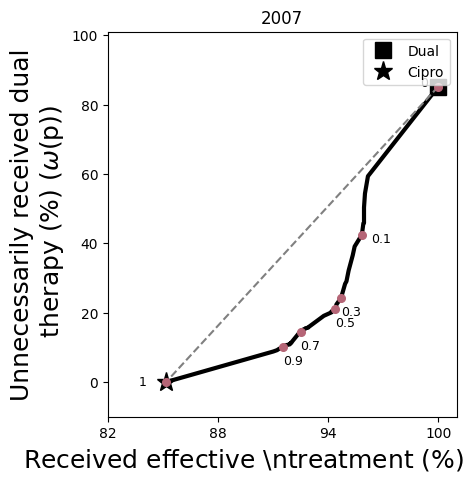

In [7]:
###### Effect of threshold on year-by-year for neural network - 2007 only - CONFERENCE PROPOSAL
fig, axs = plt.subplots( figsize=(4.5, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
text_for_graph = ['0', '0.1','0.3', '0.5', '0.7', '0.9', '1']
#indices = [0,10,20,30,40,50,60,70,80,90,100]
indices = [0,10,30,50,70,90,100]

axs.set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs.set_xlabel(r'Received effective \ntreatment (%) ($\theta$(p))', fontsize = 18)

axs.set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs.set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs.set_ylim([0-10,101])
axs.set_xlim([82, 101])

years = [2007]
threshold_seq = np.linspace(0,1,101)

for year in years:
    years_train = np.array(range(year - 5, year))
    
    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size=0.5)
   
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs.plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "Dual")
    axs.plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs.plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs.set_title(year,fontsize=12)
    x = 0
    for index in indices:
        axs.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index == 100:
            axs.text(get_effective_threshold[index] - 1.5, incorrectly_get_X_threshold[index] - 1, text_for_graph[x], size = 9)
        elif index == 0:
            axs.text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index], text_for_graph[x], size = 9)
        elif (get_effective_threshold[index] > 95) & (get_effective_threshold[index] < 99.6):
            if abs(get_effective_threshold[index] - get_effective_threshold[index-10]) < 0.3:
                if (incorrectly_get_X_threshold[index] - incorrectly_get_X_threshold[index-10] < 1):
                    axs.text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*1.01, text_for_graph[x], size = 9)#, color = "blue")
                else:
                    axs.text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 9)#, color = "green")
            else:
                axs.text(get_effective_threshold[index]*1.005, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 9)#, color = "red")
        
        else:
            axs.text(get_effective_threshold[index]- 0.01, incorrectly_get_X_threshold[index]-5, text_for_graph[x], size = 9)
        
        x = x+1

axs.legend()
plt.savefig('Graphs/Percent_effective_unnecessary_all_neural_network_2007_grant.png')

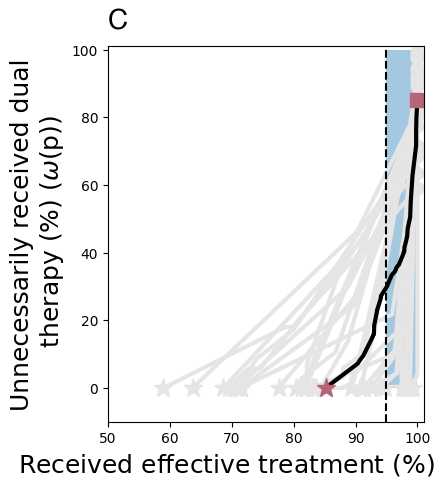

In [12]:
### Leave one out validation for MLP 
from matplotlib.patches import Polygon
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
fig, axs = plt.subplots( figsize=(4.5, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
threshold_seq = np.linspace(0,1,101)

text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]


axs.set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs.set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs.set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs.set_xticks(np.linspace(50,100,6), fontsize=18,**hfont)

test_years = [2007]
axs.set_ylim([0-10,101])
axs.set_xlim([50, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size = 0.5)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[ best_features_by_year_nn[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[ best_features_by_year_nn[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          #print(cipro_R)
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   

          
          except ValueError:
            #try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=1)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              #y_test.astype(y_predict_test.dtype)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs.plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs.plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs.plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   


            #except ValueError:
              #print('x')
              #pass
    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs.plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs.plot(100, 100 - cipro_R_prev*100, marker='s', ls='none', ms=10, color = "#b56576")
    axs.plot((100-cipro_R_prev*100), 0, marker='*', ls='none', ms=14, color = "#b56576")
    axs.text(axs.get_xlim()[0], axs.get_ylim()[1] + 5, "C", fontsize = 20, **hfont)
    axs.axvline(x = 95, color = 'black', linestyle="--")


    i += 1   #

axs.add_patch(polygon_important0)
plt.tight_layout()

#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_neural_network_2005_2010.png", dpi = 600)